# <center>Solving the Mountain Car Problem with Reinforcement Learning</center> 


## Contents

<a href='#importlibraries'> 1 Importing Core Libraries</a>

<a href='#MCv0'> 2 MountainCar-v0 Environment</a>

<a href='#DiscSS'> 3 Discretizing State Space</a>

<a href='#Qlearn'> 4 Building Q-learning Algorithm</a>

-  <a href='#Qlearn1'> 4.1 Q-Value</a>
-  <a href='#Qlearn2'> 4.2 Max Action Function</a>

<a href='#baseline'> 5 Baseline model</a>

<a href='#part6' > 6 Evaluating Performance with Varying Parameters </a>

- <a href='#part6a' > 6a Varying Alpha </a>
    
- <a href='#part6b' > 6b Varying Gamma </a> 

- <a href='#part6c' > 6c Varying Epsilon </a> 

- <a href='#part6d' > 6d Varying Policy </a> 

<a href='#part7' > 7 Deep Q-learning</a>

- <a href='#part7a' > 7a Varying Learning Rate </a>
    
- <a href='#part7b' > 7b Varying Gamma </a> 



<a href='#part8' > 8 Advantage Actor Critic</a>

- <a href='#part8a' > 8a Successful Results </a>
    
- <a href='#part8b' > 8b Unsuccessful Results </a> 

<a id='importlibraries'></a>

### 1 Importing Core Libraries

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import gym
import time 

<a id='MCv0'></a>

### 2 MountainCar-v0 Environment

Import the MountainCar-v0 environment from OpenAI gym and then perform a simple simulation to understand how the environment functions. 

In [327]:
#Import the environment
env = gym.make('MountainCar-v0')
env._max_episode_steps = 25000 # changing from default of 200 


env.reset()
for i in range(3):
    #env.render()
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    print('Step: {}'.format(i))
    print('Action: {} ({})'.format(action, 'push left' if action == 0 else 'no push' if action == 1 else 'push right'))
    print('Position: {}'.format(observation[0]))
    print('Velocity: {}'.format(observation[1]))
    print('Reward earned:{}'.format(reward))       
    print('Goal reached? : {}'.format(done))
    print('\n')

Step: 0
Action: 2 (push right)
Position: -0.5758594036748989
Velocity: 0.001400724041498902
Reward earned:-1.0
Goal reached? : False


Step: 1
Action: 0 (push left)
Position: -0.5750683286948047
Velocity: 0.0007910749800941672
Reward earned:-1.0
Goal reached? : False


Step: 2
Action: 0 (push left)
Position: -0.5748927641624793
Velocity: 0.00017556453232544047
Reward earned:-1.0
Goal reached? : False




Above, an illustration of what happens 'under the bonnet' when the agent takes 3 actions. 

The agent has been programmed to take random actions. Notice the position and velocity values changed at each step. 

The rewards earned are -1 for each action. 

Also, its possible to determine if the goal has been reached by each action. 

In [3]:
#Getting the state and action spaces object types

print('State space:', env.observation_space)

print('Action space:', env.action_space) # 0:push left, 1: no push, 2: push right 

State space: Box(2,)
Action space: Discrete(3)


The state space is a 'Box' type with 2 real numbers, which represent position and velocity. 

The action space is a 'Discrete' type with 3 numbers, meaning that there are 3 discrete actions, namely push left, no push and push right. 

In [4]:
# Given the state space is a 2d array, (pos , vec) , we want to know the min and max of the continous state space for both position and velocity

print('The ranges for the position state are: \nMin: {} Max: {}'.format(round(env.observation_space.low[0],3), env.observation_space.high[0] ))
print('\n')
print('The ranges for the velocity state are: \nMin: {} Max: {}'.format(env.observation_space.low[1], env.observation_space.high[1] ))

The ranges for the position state are: 
Min: -1.2000000476837158 Max: 0.6000000238418579


The ranges for the velocity state are: 
Min: -0.07000000029802322 Max: 0.07000000029802322


<a id='DiscSS'></a>

### 3 Discretizing State Space

To apply Q-learning to our environment, the state spaces must be discretised. This is done by dividing our bounded state spaces into a specified number of bins(chosen to be 25 bins). 



In [7]:
# Creating discrete state spaces for position and velocity 
# The np.linspace function splits a range of real numbers into a number of bins. 


actions=[0,1,2] #0:push left, 1: no push, 2: push right 

position_vec = np.linspace(env.observation_space.low[0] , env.observation_space.high[0], 25)

velocity_vec = np.linspace(env.observation_space.low[1] , env.observation_space.high[1], 25)

## We now need a function which takes state space values from the environment, and places them into our discrete state spaces created above. We use np.digitize for this. 

def discrete_state(state):
    position, velocity = state
    #disc_pos = position_vec[np.digitize(position, position_vec)]
    #disc_vel = velocity_vec[np.digitize(velocity, velocity_vec)]
    disc_pos = np.digitize(position, position_vec)
    disc_vel = np.digitize(velocity, velocity_vec)
    
    return (disc_pos , disc_vel)

In [6]:
env.seed(123)

env.reset()
for i in range(3):
    #env.render()
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    print('Step: {}'.format(i))
    print('Action: {} ({})'.format(action, 'push left' if action == 0 else 'no push' if action == 1 else 'push right'))
    print('Actual Position: {}'.format(observation[0]))
    print('Position Bin: {}'.format(discrete_state(observation)[0]))
    print('Actual Velocity: {}'.format(observation[1]))
    print('Velocity Bin: {}'.format(discrete_state(observation)[1]))
    print('\n')

Step: 0
Action: 2 (push right)
Actual Position: -0.45791046405982594
Position Bin: 10
Actual Velocity: 0.0005143034015772355
Velocity Bin: 13


Step: 1
Action: 1 (no push)
Actual Position: -0.45788564045752184
Position Bin: 10
Actual Velocity: 2.482360230409656e-05
Velocity Bin: 13


Step: 2
Action: 2 (push right)
Actual Position: -0.45735047922678074
Position Bin: 10
Actual Velocity: 0.0005351612307411115
Velocity Bin: 13




Now we make a list of all combinations of state space pairs. 

In [8]:
states=[]

for pos in range(len(position_vec)):
    for vel in range(len(velocity_vec)):
        states.append((pos,vel)) 

# Alternative         
#for pos in range( len(position_vec) + 1 ):
#    for vel in range( len(velocity_vec) + 1 ):
#       states.append((pos,vel)) 


<a id='Qlearn'></a>

### 4 Building Q-learning Algorithm

The components of the Q-learning Algorithm are:

- Alpha - learning rate
- Gamma - Discount rate
- Reward function
- Q-Value
- Max Action 


We will specify Alpha and Gamma, the reward function is given in the environment, so we need to define the Max Action function and Q-Value variable. 

<a id='Qlearn1'></a>
#### 4.1 Q-Value


In [52]:
# Create Q-value dictionary         
Q = {}

for state in states:
    for action in actions:
        Q[state, action] = 0 # All Q-values need to be equal to zero initially 

The above creates a dictionary version of the Q-matrix. 

The key in the dictionary represents a state space, and each action for that state space. 

The value in the dictionary is the Q-value, i.e. the expected cumulative reward for the state-action pair. The Q-values are all initialised as zero. 

This is illustrated below. 

In [48]:
from itertools import islice


# https://stackoverflow.com/questions/7971618/python-return-first-n-keyvalue-pairs-from-dict
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

# Show 5 values from the Q-matrix
take(5, Q.items())

[(((0, 0), 0), 0),
 (((0, 0), 1), 0),
 (((0, 0), 2), 0),
 (((0, 1), 0), 0),
 (((0, 1), 1), 0)]

<a id='Qlearn2'></a>
#### 4.2 Max Action Function


In [9]:
## Def function that determines action with max Q

def max_Q(Q, state, actions=[0,1,2]):
    values = np.array([Q[state,action] for action in actions]) #constructng Q-values for all actions 
    action = np.argmax(values)
    
    return action 

<a id='baseline'></a>
### 5 Baseline Model

In [53]:
#Set parameters
num_episodes = 5000
alpha = 0.5 # learning rate
gamma = 0.8 # discouunt rate
epsilon = 0.5 # epsilon value for epsilon-greedy policy  


# Run algorithm below 

total_rewards = np.zeros(num_episodes)

start_time = time.time()
for i in range(num_episodes):
    if i%500==0: print('Episode: {}'.format(i)) # track progress of learning
    
    done = False # Reset True value, as new episode begin
    state = env.reset() # Restart state 
    state = discrete_state(state) # Use function created to convert state into discrete 
    score = 0 
    while not done:
        #env.render()
        random_number = np.random.random() # random number for epsilon-greedy policy
        action = env.action_space.sample() if random_number < epsilon else max_Q(Q, state) # action to take, determined by epsilon-greedy policy 
        
        state_2, reward, done, info = env.step(action) # Take action , and determine new state 
        state_2 = discrete_state(state_2) # convert continuous state to discrete 
        
        score += reward
        action_2 = max_Q(Q, state_2)
        #print(Q[state,action])
        Q[state,action] = Q[state, action] + alpha*(reward + gamma*Q[state_2, action_2] - Q[state, action])
        #print(Q[state,action])
        state = state_2        
         
    #env.close()
    total_rewards[i] = score
    
    epsilon = epsilon - 10/num_episodes if epsilon > 0.01 else 0.01 # method to decrease epsilon each episode 
    
print("--- %s minutes ---" % round(((time.time() - start_time)/60),3))    
    

Episode: 0
Episode: 500
Episode: 1000
Episode: 1500
Episode: 2000
Episode: 2500
Episode: 3000
Episode: 3500
Episode: 4000
Episode: 4500
--- 1.839 minutes ---


In [200]:
# Function for moving average, : https://gist.github.com/rday/5716218

def moving_average(data_set, periods=3):
    weights = np.ones(periods) / periods
    return np.convolve(data_set, weights, mode='valid')

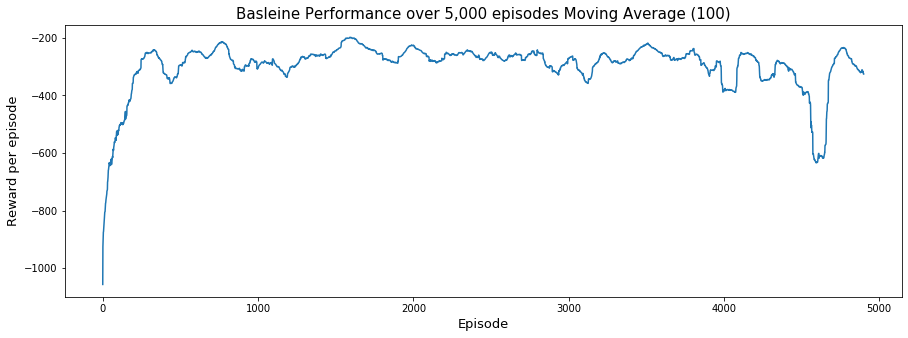

In [107]:
################

ma = moving_average(total_rewards, 100)

plt.figure(figsize=(15,5))
plt.title('Basleine Performance over 5,000 episodes Moving Average (100)', fontsize=15)
plt.plot(ma)
plt.ylabel('Reward per episode', fontsize=13)
plt.xlabel('Episode', fontsize=13)
plt.savefig('Baseline_moving_avg.jpg')
plt.show()

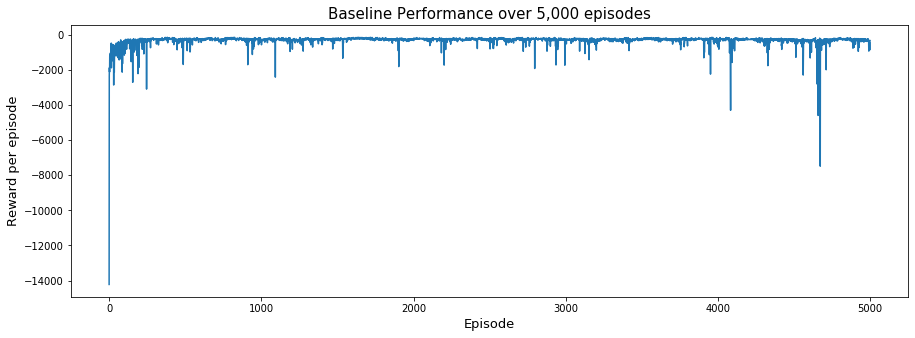

In [108]:
plt.figure(figsize=(15,5))
plt.title('Baseline Performance over 5,000 episodes', fontsize=15)
plt.plot(total_rewards)
plt.ylabel('Reward per episode', fontsize = 13)
plt.xlabel('Episode', fontsize = 13)
plt.savefig('Baseline_actual.jpg')
plt.show()

In [63]:
#Save results 
np.savetxt('baseline2.csv', total_rewards, delimiter=',')

<a id='part6'></a>
### 6 Evaluating Performance with Varying Parameters

<a id='part6a'></a>
#### 6a Varying Alpha

In [80]:
#Set parameters
num_episodes = 5000
alpha = [0.01, 0.25, 0.75, 1] # learning rate
gamma = 0.8 # discouunt rate



list_of_rewards = [[] for i in alpha]

# Run algorithm below 

for i,j in enumerate(alpha): 
    
    ############
    Q = {}

    for state in states:
        for action in actions:
            Q[state, action] = 0  # initialising Q-matrix as zero for every alpha 

    ###########
    
    epsilon = 0.5 # making epsilon start at 0.5 for each alpha 
    
    ################
    
    start_time = time.time() # time learning process for each parameter 
    
    print('Learning with alpha = {}'.format(j))
    
    for e in range(num_episodes):
        if e%500==0: print('Episode: {}'.format(e)) # track progress of learning 

        done = False # Reset True value, as new episode begin
        state = env.reset() # Restart state 
        state = discrete_state(state) # Use function created to convert state into discrete 
        score = 0 
        while not done:
            #env.render()
            random_number = np.random.random() # random number for epsilon-greedy policy
            action = env.action_space.sample() if random_number < epsilon else max_Q(Q, state) # action to take, determined by epsilon-greedy policy 

            state_2, reward, done, info = env.step(action) # Take action , and determine new state 
            state_2 = discrete_state(state_2) # convert continuous state to discrete 

            score += reward
            action_2 = max_Q(Q, state_2)

            Q[state,action] = Q[state, action] + j*(reward + gamma*Q[state_2, action_2] - Q[state, action])

            state = state_2        

        #env.close()
        list_of_rewards[i].append(score)

        epsilon = epsilon - 10/num_episodes if epsilon > 0.01 else 0.01 # method to decrease epsilon each episode 
    
    print("Learning completed in %s minutes \n" % round(((time.time() - start_time)/60),3))    

Learning with alpha = 0.01
Episode: 0
Episode: 500
Episode: 1000
Episode: 1500
Episode: 2000
Episode: 2500
Episode: 3000
Episode: 3500
Episode: 4000
Episode: 4500
Learning completed in 3.051 minutes 

Learning with alpha = 0.25
Episode: 0
Episode: 500
Episode: 1000
Episode: 1500
Episode: 2000
Episode: 2500
Episode: 3000
Episode: 3500
Episode: 4000
Episode: 4500
Learning completed in 1.393 minutes 

Learning with alpha = 0.75
Episode: 0
Episode: 500
Episode: 1000
Episode: 1500
Episode: 2000
Episode: 2500
Episode: 3000
Episode: 3500
Episode: 4000
Episode: 4500
Learning completed in 2.266 minutes 

Learning with alpha = 1
Episode: 0
Episode: 500
Episode: 1000
Episode: 1500
Episode: 2000
Episode: 2500
Episode: 3000
Episode: 3500
Episode: 4000
Episode: 4500
Learning completed in 134.807 minutes 



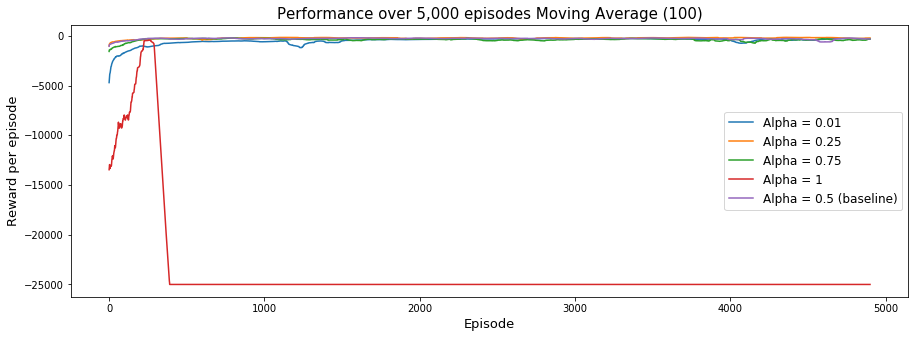

In [116]:
# Plot learning rates Vs episodes
plt.figure(figsize=(15,5))
plt.title('Performance over 5,000 episodes Moving Average (100)', fontsize = 15 )

for i,j in enumerate([0.01, 0.25, 0.75, 1]):
    plt.plot(moving_average(list_of_rewards[i],100), label='Alpha = {}'.format(j))

plt.plot(moving_average(total_rewards,100), label='Alpha = 0.5 (baseline)')
plt.ylabel('Reward per episode', fontsize = 13)
plt.xlabel('Episode', fontsize = 13)
plt.legend(loc='best', fontsize=12)
plt.savefig('alpha_moving_avg1.jpg')
plt.show()

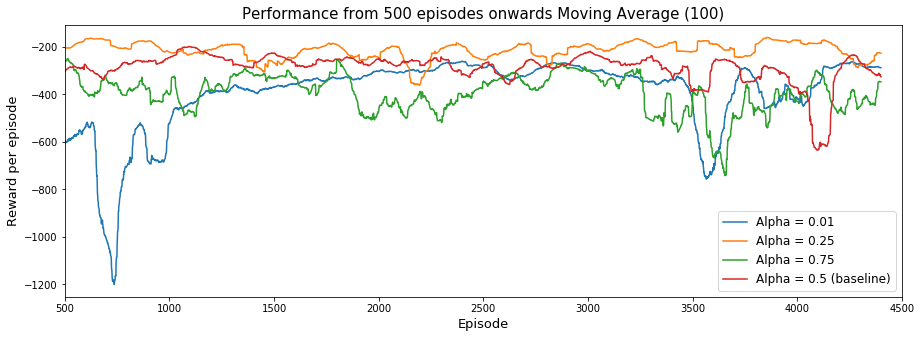

In [122]:
# Plot Learning rates Vs episodes removing alpha = 1
plt.figure(figsize=(15,5))
plt.title('Performance from 500 episodes onwards Moving Average (100)', fontsize = 15 )

for i,j in enumerate([0.01, 0.25, 0.75]):
    plt.plot(moving_average(list_of_rewards[i][500:],100), label='Alpha = {}'.format(j))

plt.plot(moving_average(total_rewards[500:],100), label='Alpha = 0.5 (baseline)')
plt.ylabel('Reward per episode', fontsize = 13)
plt.xlabel('Episode', fontsize = 13)
plt.legend(loc='best', fontsize=12)
plt.xlim(500,4500)
plt.savefig('alpha_moving_avg2.jpg')
plt.show()

<a id='part6b'></a>
#### 6b Varying Gamma

In [152]:
#Set parameters
num_episodes = 5000
alpha = 0.25 # Chosen best from above 6a
gamma = [0.1, 0.25, 0.5, 0.75, 0.8, 1] # discouunt rate



list_of_rewards2 = [[] for i in gamma]

# Run algorithm below 

for i,j in enumerate(gamma): 
    
    ############
    Q = {}

    for state in states:
        for action in actions:
            Q[state, action] = 0  # initialising Q-matrix as zero for every alpha 

    ###########
    
    epsilon = 0.5 # making epsilon start at 0.5 for each alpha 
    
    ################
    
    start_time = time.time() # time learning process for each parameter 
    
    print('Learning with gamma = {}'.format(j))
    
    for e in range(num_episodes):
        if e%500==0: print('Episode: {}'.format(e)) # track progress of learning 

        done = False # Reset True value, as new episode begin
        state = env.reset() # Restart state 
        state = discrete_state(state) # Use function created to convert state into discrete 
        score = 0 
        while not done:
            #env.render()
            random_number = np.random.random() # random number for epsilon-greedy policy
            action = env.action_space.sample() if random_number < epsilon else max_Q(Q, state) # action to take, determined by epsilon-greedy policy 

            state_2, reward, done, info = env.step(action) # Take action , and determine new state 
            state_2 = discrete_state(state_2) # convert continuous state to discrete 

            score += reward
            action_2 = max_Q(Q, state_2)

            Q[state,action] = Q[state, action] + alpha*(reward + j*Q[state_2, action_2] - Q[state, action])

            state = state_2        

        #env.close()
        list_of_rewards2[i].append(score)

        epsilon = epsilon - 10/num_episodes if epsilon > 0.01 else 0.01 # method to decrease epsilon each episode 
    
    print("Learning completed in %s minutes \n" % round(((time.time() - start_time)/60),3))    

Learning with gamma = 0.1
Episode: 0
Episode: 500
Episode: 1000
Episode: 1500
Episode: 2000
Episode: 2500
Episode: 3000
Episode: 3500
Episode: 4000
Episode: 4500
Learning completed in 150.304 minutes 

Learning with gamma = 0.25
Episode: 0
Episode: 500
Episode: 1000
Episode: 1500
Episode: 2000
Episode: 2500
Episode: 3000
Episode: 3500
Episode: 4000
Episode: 4500
Learning completed in 62.571 minutes 

Learning with gamma = 0.5
Episode: 0
Episode: 500
Episode: 1000
Episode: 1500
Episode: 2000
Episode: 2500
Episode: 3000
Episode: 3500
Episode: 4000
Episode: 4500
Learning completed in 2.079 minutes 

Learning with gamma = 0.75
Episode: 0
Episode: 500
Episode: 1000
Episode: 1500
Episode: 2000
Episode: 2500
Episode: 3000
Episode: 3500
Episode: 4000
Episode: 4500
Learning completed in 1.596 minutes 

Learning with gamma = 0.8
Episode: 0
Episode: 500
Episode: 1000
Episode: 1500
Episode: 2000
Episode: 2500
Episode: 3000
Episode: 3500
Episode: 4000
Episode: 4500
Learning completed in 1.522 minut

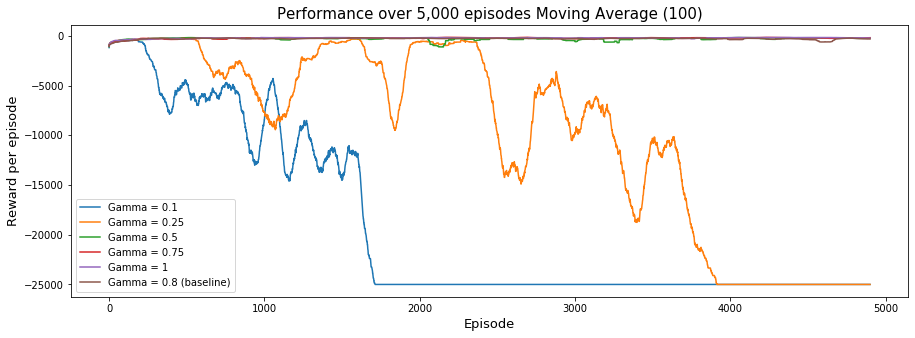

In [153]:
# Plot Gamma Vs episodes
plt.figure(figsize=(15,5))
plt.title('Performance over 5,000 episodes Moving Average (100)', fontsize=15)

for i,j in enumerate([0.1, 0.25, 0.5, 0.75, 1]):
    plt.plot(moving_average(list_of_rewards2[i],100), label='Gamma = {}'.format(j))

plt.plot(moving_average(total_rewards,100), label='Gamma = 0.8 (baseline)')
plt.ylabel('Reward per episode', fontsize=13)
plt.xlabel('Episode', fontsize=13)
plt.legend(loc='best')
plt.savefig('gamma_moving_avg1.jpg')
plt.show()

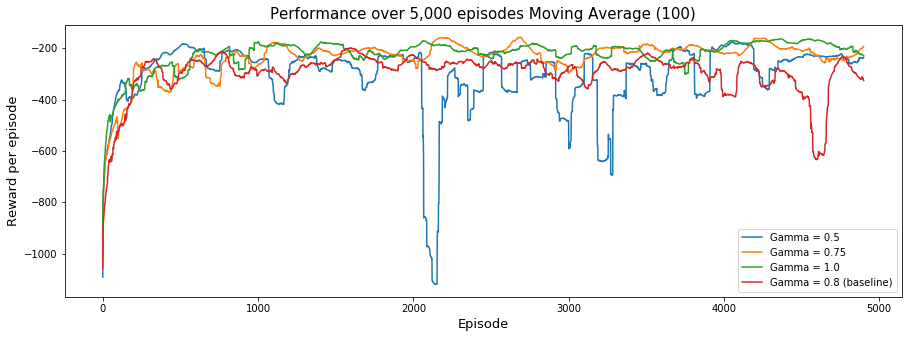

In [155]:
# Plot gamma vs Episodes to examine only suitable values
plt.figure(figsize=(15,5))
plt.title('Performance over 5,000 episodes Moving Average (100)', fontsize=15)
    
plt.plot(moving_average(list_of_rewards2[2],100), label='Gamma = 0.5')

plt.plot(moving_average(list_of_rewards2[3],100), label='Gamma = 0.75')

plt.plot(moving_average(list_of_rewards2[4],100), label='Gamma = 1.0')

plt.plot(moving_average(total_rewards,100), label='Gamma = 0.8 (baseline)')
plt.ylabel('Reward per episode', fontsize=13)
plt.xlabel('Episode', fontsize=13)
plt.legend(loc='best')
plt.savefig('gamma_moving_avg2.jpg')
plt.show()

<a id='part6c'></a>
#### 6c Varying Epsilon

In [166]:
#Set parameters
num_episodes = 5000
alpha = 0.25 # best from above 
gamma = 1 # best from above 

epsilon = [0.1, 0.25, 0.5 ,0.75, 1]

list_of_rewards3 = [[] for i in epsilon]

# Run algorithm below 

for i,j in enumerate(epsilon): 
    
    ############
    Q = {}

    for state in states:
        for action in actions:
            Q[state, action] = 0  # initialising Q-matrix as zero for every alpha 

    ###########
    
    epsilon_ = j # making epsilon start at each varied value as above 
    
    ################
    
    start_time = time.time() # time learning process for each parameter 
    
    print('Learning with epsilon = {}'.format(j))
    
    for e in range(num_episodes):
        if e%500==0: print('Episode: {}'.format(e)) # track progress of learning 

        done = False # Reset True value, as new episode begin
        state = env.reset() # Restart state 
        state = discrete_state(state) # Use function created to convert state into discrete 
        score = 0 
        while not done:
            #env.render()
            random_number = np.random.random() # random number for epsilon-greedy policy
            action = env.action_space.sample() if random_number < epsilon_ else max_Q(Q, state) # action to take, determined by epsilon-greedy policy 

            state_2, reward, done, info = env.step(action) # Take action , and determine new state 
            state_2 = discrete_state(state_2) # convert continuous state to discrete 

            score += reward
            action_2 = max_Q(Q, state_2)

            Q[state,action] = Q[state, action] + alpha*(reward + gamma*Q[state_2, action_2] - Q[state, action])

            state = state_2        

        #env.close()
        list_of_rewards3[i].append(score)

        epsilon_ = epsilon_ - 10/num_episodes if epsilon_ > 0.01 else 0.01 # method to decrease epsilon each episode 
    
    print("Learning completed in %s minutes \n" % round(((time.time() - start_time)/60),3))    

Learning with epsilon = 0.1
Episode: 0
Episode: 500
Episode: 1000
Episode: 1500
Episode: 2000
Episode: 2500
Episode: 3000
Episode: 3500
Episode: 4000
Episode: 4500
Learning completed in 1.307 minutes 

Learning with epsilon = 0.25
Episode: 0
Episode: 500
Episode: 1000
Episode: 1500
Episode: 2000
Episode: 2500
Episode: 3000
Episode: 3500
Episode: 4000
Episode: 4500
Learning completed in 1.356 minutes 

Learning with epsilon = 0.5
Episode: 0
Episode: 500
Episode: 1000
Episode: 1500
Episode: 2000
Episode: 2500
Episode: 3000
Episode: 3500
Episode: 4000
Episode: 4500
Learning completed in 1.49 minutes 

Learning with epsilon = 0.75
Episode: 0
Episode: 500
Episode: 1000
Episode: 1500
Episode: 2000
Episode: 2500
Episode: 3000
Episode: 3500
Episode: 4000
Episode: 4500
Learning completed in 1.673 minutes 

Learning with epsilon = 1
Episode: 0
Episode: 500
Episode: 1000
Episode: 1500
Episode: 2000
Episode: 2500
Episode: 3000
Episode: 3500
Episode: 4000
Episode: 4500
Learning completed in 2.329 m

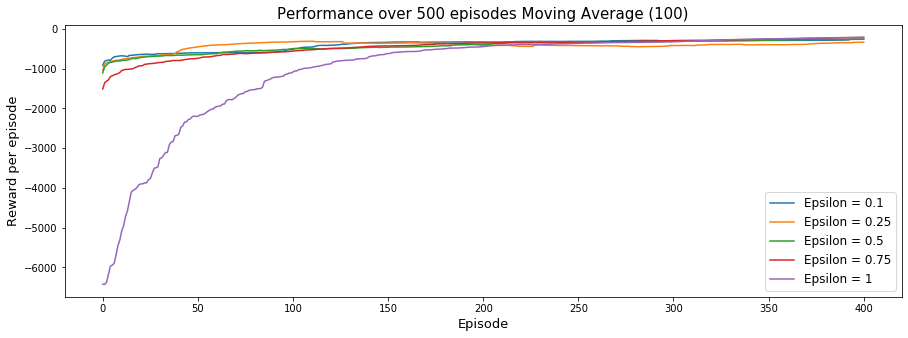

In [180]:
# Plot Epsilon vs Episodes
plt.figure(figsize=(15,5))
plt.title('Performance over 500 episodes Moving Average (100)', fontsize = 15 )


for i,j in enumerate(epsilon):
   plt.plot(moving_average(list_of_rewards3[i][0:500],100), label='Epsilon = {}'.format(j))


plt.ylabel('Reward per episode', fontsize = 13)
plt.xlabel('Episode', fontsize = 13)
plt.legend(loc='best', fontsize=12)
plt.savefig('ep_moving_avg1.jpg')
plt.show()

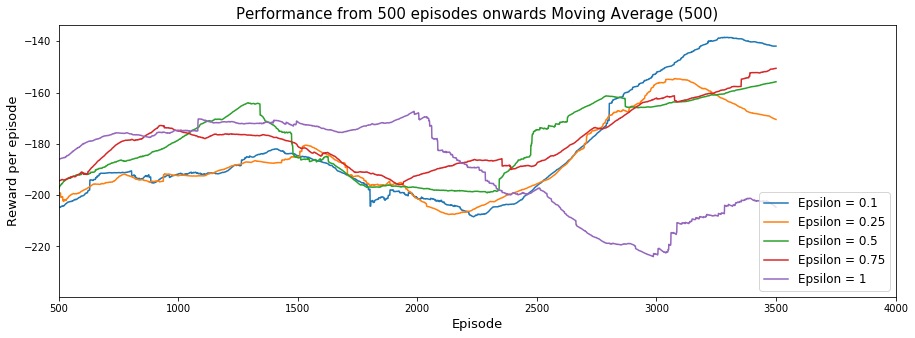

In [183]:
plt.figure(figsize=(15,5))
plt.title('Performance from 500 episodes onwards Moving Average (500)', fontsize = 15 )

for i,j in enumerate(epsilon):
    plt.plot(moving_average(list_of_rewards3[i][500:],500), label='Epsilon = {}'.format(j))

plt.ylabel('Reward per episode', fontsize = 13)
plt.xlabel('Episode', fontsize = 13)
plt.legend(loc='best', fontsize=12)
plt.xlim(500,4000)
plt.savefig('ep_moving_avg2.jpg')
plt.show()

<a id='part6d'></a>
#### 6d Varying Policy

In [15]:
random.seed(30)

#Set parameters
num_episodes = 5000
alpha = 0.25 # best from above 
gamma = 1 # best from above 
epsilon=0.5
policies = ['random', 'e-greedy', 'greedy']

list_of_rewards4 = [[] for i in policies]

# Run algorithm below 

for i,j in enumerate(policies): 
    
    ############
    Q = {}

    for state in states:
        for action in actions:
            Q[state, action] = 0  # initialising Q-matrix as zero for every alpha 

    ###########
    
    ################
    
    start_time = time.time() # time learning process for each parameter 
    
    print('Learning with Policy = {}'.format(j))
    
    for e in range(num_episodes):
        if e%500==0: print('Episode: {}'.format(e)) # track progress of learning 

        done = False # Reset True value, as new episode begin
        state = env.reset() # Restart state 
        state = discrete_state(state) # Use function created to convert state into discrete 
        score = 0 
        while not done:
            #env.render()
            
            if j == 'e-greedy':
                random_number = np.random.random() # random number for epsilon-greedy policy
                action = env.action_space.sample() if random_number < epsilon else max_Q(Q, state) # action to take, determined by epsilon-greedy policy 
            
            
            elif j == 'random':
                  action = random.randint(a=0, b=2)
            
            
            elif j == 'greedy':
                    action = max_Q(Q, state)
            
                      
            state_2, reward, done, info = env.step(action) # Take action , and determine new state 
            state_2 = discrete_state(state_2) # convert continuous state to discrete 

            score += reward
            action_2 = max_Q(Q, state_2)

            Q[state,action] = Q[state, action] + alpha*(reward + gamma*Q[state_2, action_2] - Q[state, action])

            state = state_2        

        #env.close()
        list_of_rewards4[i].append(score)

        
        if j == 'e-greedy':
            epsilon = epsilon - 10/num_episodes if epsilon > 0.01 else 0.01 # to decrease epsilon each episode 
    
    print("Learning completed in %s minutes \n" % round(((time.time() - start_time)/60),3))    
    

Learning with Policy = random
Episode: 0
Episode: 500
Episode: 1000
Episode: 1500
Episode: 2000
Episode: 2500
Episode: 3000
Episode: 3500
Episode: 4000
Episode: 4500
Learning completed in 125.365 minutes 

Learning with Policy = e-greedy
Episode: 0
Episode: 500
Episode: 1000
Episode: 1500
Episode: 2000
Episode: 2500
Episode: 3000
Episode: 3500
Episode: 4000
Episode: 4500
Learning completed in 1.288 minutes 

Learning with Policy = greedy
Episode: 0
Episode: 500
Episode: 1000
Episode: 1500
Episode: 2000
Episode: 2500
Episode: 3000
Episode: 3500
Episode: 4000
Episode: 4500
Learning completed in 1.152 minutes 



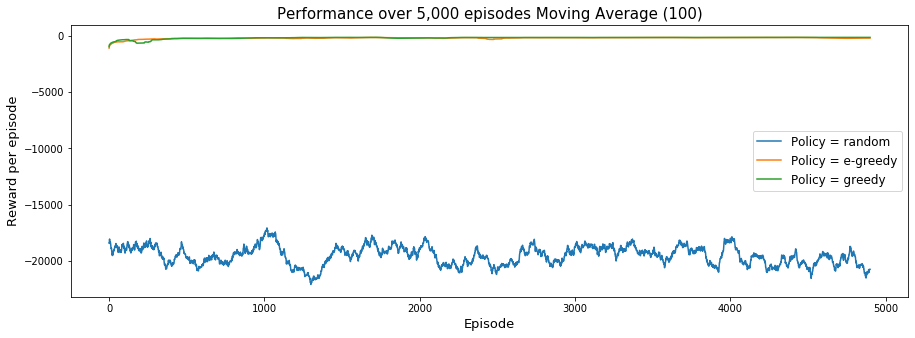

In [24]:
# Plot results for different Policies Vs Episodes
plt.figure(figsize=(15,5))
plt.title('Performance over 5,000 episodes Moving Average (100)', fontsize = 15 )

for i,j in enumerate(policies):
   plt.plot(moving_average(list_of_rewards4[i][0:5000],100), label='Policy = {}'.format(j))


plt.ylabel('Reward per episode', fontsize = 13)
plt.xlabel('Episode', fontsize = 13)
plt.legend(loc='best', fontsize=12)
plt.savefig('varying_policies.jpg')
plt.show()

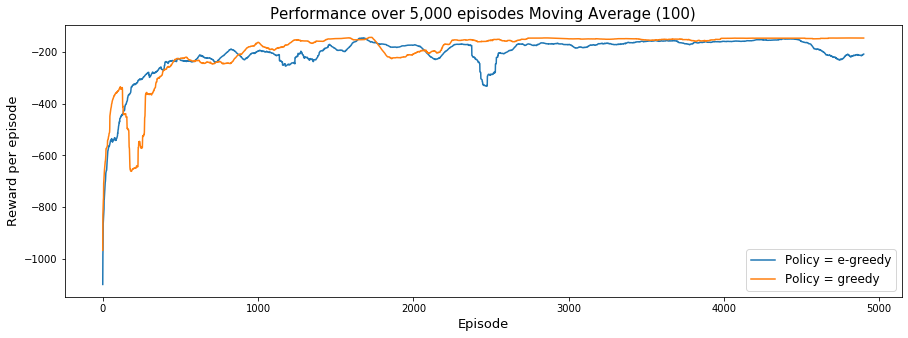

In [27]:
plt.figure(figsize=(15,5))
plt.title('Performance over 5,000 episodes Moving Average (100)', fontsize = 15 )

plt.plot(moving_average(list_of_rewards4[1][0:5000],100), label='Policy = e-greedy')

plt.plot(moving_average(list_of_rewards4[2][0:5000],100), label='Policy = greedy')


plt.ylabel('Reward per episode', fontsize = 13)
plt.xlabel('Episode', fontsize = 13)
plt.legend(loc='best', fontsize=12)
plt.savefig('varying_policies2.jpg')
plt.show()

<a id='part7'></a>
### 7 Deep Q-learning

We now use DQNs in the environment, allowing the agent to fully explore the states as continous values. 

Ref: https://github.com/branavg/Deep-Q-learning/blob/master/Mountain%20Car.ipynb

#### Import libraries 

In [135]:
from keras import models
from keras import layers
from keras.optimizers import Adam
from collections import deque

Class created for the mountain car environment which contains all functions associated with the DQN algorithm.

In [355]:
class MountainCarTrain:
    def __init__(self,env):
        # initialise values
        self.env=env
        self.gamma=0.99
        self.epsilon = 0.5
        self.epsilon_decay = 0.002
        self.epsilon_min=0.01
        self.learingRate=0.001
        
        # Set Replay memory size
        self.replayBuffer=deque(maxlen=20000)
        self.trainNetwork=self.createNetwork()

        self.episodeNum=5000

        # Max number of steps 
        self.iterationNum=1001 #max was 200
        
        self.rewardSums = np.zeros(self.episodeNum)
        
        # Memory buffer size
        self.numPickFromBuffer=120

        self.targetNetwork=self.createNetwork()

        self.targetNetwork.set_weights(self.trainNetwork.get_weights())

    def createNetwork(self):
        model = models.Sequential()
        state_shape = self.env.observation_space.shape

        model.add(layers.Dense(24, activation='relu', input_shape=state_shape))
        model.add(layers.Dense(48, activation='relu'))
        model.add(layers.Dense(self.env.action_space.n,activation='linear'))
        # model.compile(optimizer=optimizers.RMSprop(lr=self.learingRate), loss=losses.mean_squared_error)
        model.compile(loss='mse', optimizer=Adam(lr=self.learingRate))
        return model

    def getBestAction(self,state):

        self.epsilon = max(self.epsilon_min, self.epsilon)

        if np.random.rand(1) < self.epsilon:
            action = np.random.randint(0, 3)
        else:
            action=np.argmax(self.trainNetwork.predict(state)[0])

        return action

    

    def trainFromBuffer(self):
        if len(self.replayBuffer) < self.numPickFromBuffer:
            return

        samples = random.sample(self.replayBuffer,self.numPickFromBuffer)

        states = []
        newStates=[]
        for sample in samples:
            state, action, reward, new_state, done = sample
            states.append(state)
            newStates.append(new_state)

        newArray = np.array(states)
        states = newArray.reshape(self.numPickFromBuffer, 2)

        newArray2 = np.array(newStates)
        newStates = newArray2.reshape(self.numPickFromBuffer, 2)

        targets = self.trainNetwork.predict(states)
        new_state_targets=self.targetNetwork.predict(newStates)

        i=0
        
        for sample in samples:
            state, action, reward, new_state, done = sample
            
            #Target - q-value for each action 
            target = targets[i]
            if done:
                #updating q-value with reward only if last action of episode
                target[action] = reward
            else:
                
                # If not, update in line with Bellman equation
                # Need max q-value from next state, we have next state and get max by passing this next state into network
                # and taking the maximum. This is referred to as bootstrapping, as we are updating our estimate with an estimate
                
                Q_future = max(new_state_targets[i])
                target[action] = reward + Q_future * self.gamma
            
            targets[i] = target
            i+=1

        self.trainNetwork.fit(states, targets, epochs=1, verbose=0)


    def orginalTry(self,currentState,eps):
        
        
        
        rewardSum = 0
        max_position=-99

        for i in range(self.iterationNum):
            bestAction = self.getBestAction(currentState)

            #show the animation every 50 eps
            #if eps%50==0:
            #    env.render()

            new_state, reward, done, _ = env.step(bestAction)

            new_state = new_state.reshape(1, 2)

            # # Keep track of max position
            if new_state[0][0] > max_position:
                max_position = new_state[0][0]


            # Adjust reward for task completion
            if new_state[0][0] >= 0.5:
                reward += 10

            # Append experiences to the Replay memory    
            self.replayBuffer.append([currentState, bestAction, reward, new_state, done])

            self.trainFromBuffer()

            rewardSum += reward # store rewards to plot

            currentState = new_state

            if done:
                break

        if i >= 4999:
            print("Failed to finish task in epsoide {}".format(eps))
        else:
            print("Success in epsoide {}, used {} iterations!".format(eps, i))
           
        self.targetNetwork.set_weights(self.trainNetwork.get_weights())

        print("now epsilon is {}, the reward is {} maxPosition is {}".format(max(self.epsilon_min, self.epsilon), rewardSum,max_position))
        self.epsilon -= self.epsilon_decay
        
        self.rewardSums[eps] = rewardSum
       

    def start(self):
        for eps in range(self.episodeNum):      # iterate for no. of episodes defined
            currentState=env.reset().reshape(1,2)
            self.orginalTry(currentState, eps)

### Baseline DQN

In [256]:
dqn=MountainCarTrain(env=env)

start_time = time.time()
dqn.start()
print("--- %s minutes ---" % round(((time.time() - start_time)/60),3))  

Success in epsoide 0, used 971 iterations!
now epsilon is 0.5, the reward is -962.0 maxPosition is 0.5059977429571381
Episode: 0
Success in epsoide 1, used 1000 iterations!
now epsilon is 0.498, the reward is -1001.0 maxPosition is -0.36777240229750735
Success in epsoide 2, used 1000 iterations!
now epsilon is 0.496, the reward is -1001.0 maxPosition is -0.33330494320070636
Success in epsoide 3, used 1000 iterations!
now epsilon is 0.494, the reward is -1001.0 maxPosition is -0.29092806223543
Success in epsoide 4, used 1000 iterations!
now epsilon is 0.492, the reward is -1001.0 maxPosition is -0.2891008456097981
Success in epsoide 5, used 1000 iterations!
now epsilon is 0.49, the reward is -1001.0 maxPosition is -0.260034916649691
Success in epsoide 6, used 1000 iterations!
now epsilon is 0.488, the reward is -1001.0 maxPosition is -0.23583237997834006
Success in epsoide 7, used 1000 iterations!
now epsilon is 0.486, the reward is -1001.0 maxPosition is -0.3264514274967411
Success in 

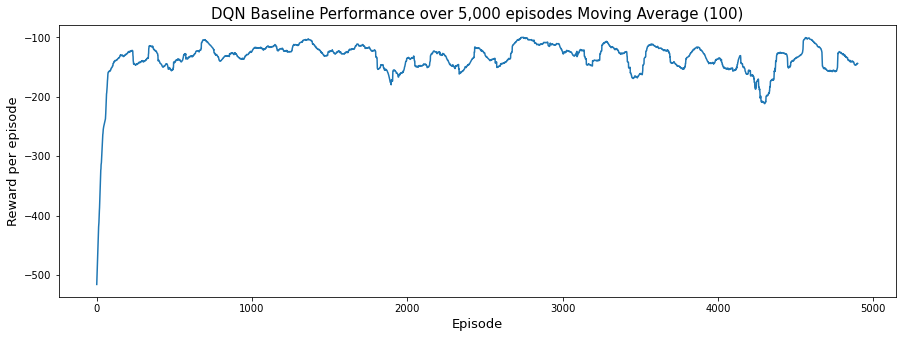

In [359]:
# Plot the Baseline performance for each episode
plt.figure(figsize=(15,5))
plt.title('DQN Baseline Performance over 5,000 episodes Moving Average (100)', fontsize=15)
plt.plot(moving_average(dqn.rewardSums,100))
plt.ylabel('Reward per episode', fontsize=13)
plt.xlabel('Episode', fontsize=13)
plt.savefig('DQN_Baseline_moving_avg.jpg')
plt.show()

In [362]:
#Save results 
np.savetxt('DQN_baseline1.csv', dqn.rewardSums, delimiter=',')

<a id='part7a'></a>
### 7a Varying Learning Rate



In [329]:
learning_rates=[0.1, 0.01, 0.0001]


learning_rate_scores = [[] for i in learning_rates]


for i,j in enumerate(learning_rates):
    
    dqn_lr=MountainCarTrain(env=env)

    #dqn_lr.episodeNum=10

    #dqn_lr.iterationNum=1000+i
    
    dqn_lr.learingRate=j
    
    #dqn_lr.rewardSums = np.zeros(dqn_lr.episodeNum)
    
    start_time = time.time()
    dqn_lr.start()
    learning_rate_scores[i].append(dqn_lr.rewardSums)
    print("--- %s minutes ---" % round(((time.time() - start_time)/60),3))  
    print('\n')
    

Success in epsoide 0, used 1000 iterations!
now epsilon is 0.5, the reward is -1001.0 maxPosition is -0.28812779429632424
Episode: 0
Success in epsoide 1, used 1000 iterations!
now epsilon is 0.498, the reward is -1001.0 maxPosition is 0.10838461530545443
Success in epsoide 2, used 1000 iterations!
now epsilon is 0.496, the reward is -1001.0 maxPosition is -0.3386327609157181
Success in epsoide 3, used 1000 iterations!
now epsilon is 0.494, the reward is -1001.0 maxPosition is 0.3966395025161519
Success in epsoide 4, used 1000 iterations!
now epsilon is 0.492, the reward is -1001.0 maxPosition is -0.4705150654395693
Success in epsoide 5, used 510 iterations!
now epsilon is 0.49, the reward is -501.0 maxPosition is 0.5164913263172678
Success in epsoide 6, used 678 iterations!
now epsilon is 0.488, the reward is -669.0 maxPosition is 0.5134628089871797
Success in epsoide 7, used 1000 iterations!
now epsilon is 0.486, the reward is -1001.0 maxPosition is -0.14908279400496297
Success in ep

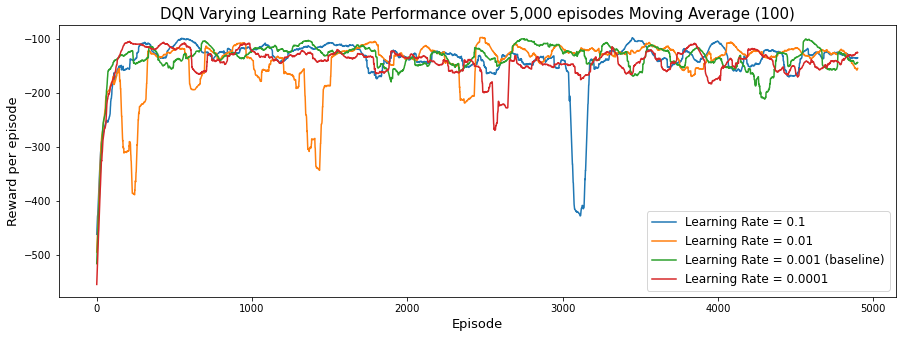

In [360]:
plt.figure(figsize=(15,5))
plt.title('DQN Varying Learning Rate Performance over 5,000 episodes Moving Average (100)', fontsize = 15 )

plt.plot(moving_average(learning_rate_scores[0][0],100), label='Learning Rate = 0.1')

plt.plot(moving_average(learning_rate_scores[1][0],100), label='Learning Rate = 0.01')

plt.plot(moving_average(dqn.rewardSums,100), label='Learning Rate = 0.001 (baseline)')

plt.plot(moving_average(learning_rate_scores[2][0],100), label='Learning Rate = 0.0001')

plt.ylabel('Reward per episode', fontsize = 13)
plt.xlabel('Episode', fontsize = 13)
plt.legend(loc='best', fontsize=12)
plt.savefig('varying_lr_dqn.jpg')
plt.show()


In [372]:
np.savetxt('lr_0.1.csv', moving_average(learning_rate_scores[0][0],100), delimiter=',')

np.savetxt('lr_0.01.csv', moving_average(learning_rate_scores[1][0],100), delimiter=',')

np.savetxt('lr_0.0001.csv', moving_average(learning_rate_scores[2][0],100), delimiter=',')

<a id='part7b'></a>
### 7b Varying Epsilon

In [356]:
initial_epsilon=[1, 0.75, 0.25]


epsilon_scores = [[] for i in initial_epsilon]


for i,j in enumerate(initial_epsilon):
    
    dqn_eps=MountainCarTrain(env=env)

    dqn_eps.epsilon=j
    
    start_time = time.time()
    dqn_eps.start()
    epsilon_scores[i].append(dqn_eps.rewardSums)
    print("--- %s minutes ---" % round(((time.time() - start_time)/60),3))  
    print('\n')

Success in epsoide 0, used 1000 iterations!
now epsilon is 1, the reward is -1001.0 maxPosition is -0.12071908361223518
Success in epsoide 1, used 1000 iterations!
now epsilon is 0.998, the reward is -1001.0 maxPosition is -0.03992237298173071
Success in epsoide 2, used 1000 iterations!
now epsilon is 0.996, the reward is -1001.0 maxPosition is -0.4010890773774795
Success in epsoide 3, used 1000 iterations!
now epsilon is 0.994, the reward is -1001.0 maxPosition is -0.17705005834076573
Success in epsoide 4, used 1000 iterations!
now epsilon is 0.992, the reward is -1001.0 maxPosition is -0.1638575900832458
Success in epsoide 5, used 1000 iterations!
now epsilon is 0.99, the reward is -1001.0 maxPosition is -0.31972719618952605
Success in epsoide 6, used 1000 iterations!
now epsilon is 0.988, the reward is -1001.0 maxPosition is -0.2862997329324214
Success in epsoide 7, used 1000 iterations!
now epsilon is 0.986, the reward is -1001.0 maxPosition is -0.28984868703908895
Success in epsoi

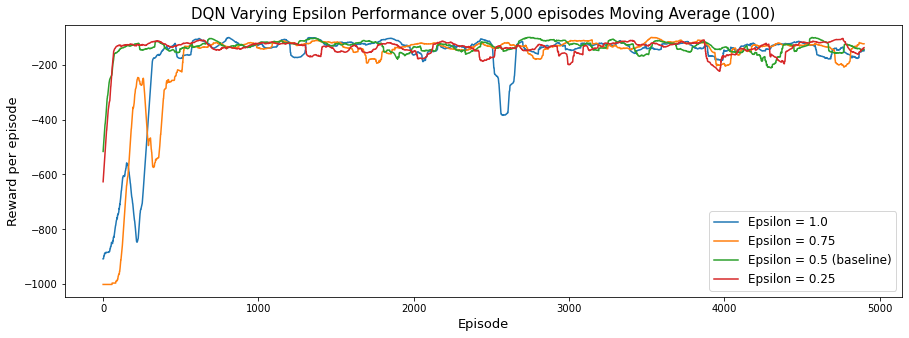

In [361]:
# Plot varying Epsilon values Vs Epsiodes
plt.figure(figsize=(15,5))


plt.title('DQN Varying Epsilon Performance over 5,000 episodes Moving Average (100)', fontsize = 15 )

plt.plot(moving_average(epsilon_scores[0][0],100), label='Epsilon = 1.0')

plt.plot(moving_average(epsilon_scores[1][0],100), label='Epsilon = 0.75')

plt.plot(moving_average(dqn.rewardSums,100), label='Epsilon = 0.5 (baseline)')

plt.plot(moving_average(epsilon_scores[2][0],100), label='Epsilon = 0.25')

plt.ylabel('Reward per episode', fontsize = 13)
plt.xlabel('Episode', fontsize = 13)
plt.legend(loc='best', fontsize=12)
plt.savefig('varying_eps_dqn.jpg')
plt.show()



In [374]:
np.savetxt('eps_1.csv', moving_average(epsilon_scores[0][0],100), delimiter=',')

np.savetxt('eps_0.75.csv', moving_average(epsilon_scores[1][0],100), delimiter=',')

np.savetxt('eps_0.25.csv', moving_average(epsilon_scores[2][0],100), delimiter=',')

<a id='part8'></a>
### 8 Advantage Actor Critic

Ref: https://github.com/andy-psai/MountainCar_ActorCritic/blob/master/RL%20Blog%20FINAL%20MEDIUM%20code%2002_12_19.ipynb

Note: This code has been tested using tensorflow version 1.15.0 and will not work with later versions.

The algorithm experiment is split into 2 parts. Owing to the nature of the algorithm and the environment, the agent can go through a training phase and fail to learn or could improve it's behaviour over time. The experiment is split to successful and unsusccessful results, and varying the parameters to explore how these can affect the learning in both scenarios. 

In [4]:
#Import libraries 
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sklearn
import sklearn.preprocessing
import warnings
warnings.filterwarnings("ignore")
# Import continuous version of environment
env = gym.envs.make("MountainCarContinuous-v0") 

<a id='part8a'></a>
### 8a Successful Results


In [ ]:
tf.reset_default_graph()

# set dimensions for position and velocity in the placeholder
input_dims = 2
state_placeholder = tf.placeholder(tf.float32, [None, input_dims]) 

# define critic network
def value_function(state):
    n_hidden1 = 400  
    n_hidden2 = 400
    n_outputs = 1
    
    # xavier initialisation for network weights
    init_xavier = tf.contrib.layers.xavier_initializer()
        
    hidden1 = tf.layers.dense(state, n_hidden1, tf.nn.elu, init_xavier)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, tf.nn.elu, init_xavier) 
    V = tf.layers.dense(hidden2, n_outputs, None, init_xavier)
    return V

# define actor network
def policy_network(state):
    n_hidden1 = 40
    n_hidden2 = 40
    n_outputs = 1
    
    # xavier initialisation for network weights
    init_xavier = tf.contrib.layers.xavier_initializer()
    
    hidden1 = tf.layers.dense(state, n_hidden1, tf.nn.elu, init_xavier)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, tf.nn.elu, init_xavier)
    mu = tf.layers.dense(hidden2, n_outputs, None, init_xavier)
    sigma = tf.layers.dense(hidden2, n_outputs, None, init_xavier)
    sigma = tf.nn.softplus(sigma) + 1e-5      # avoid zero variance
    norm_dist = tf.contrib.distributions.Normal(mu, sigma)
    # sample generated distribution to define action
    action_tf_var = tf.squeeze(norm_dist.sample(1), axis=0)
    action_tf_var = tf.clip_by_value(     # set bounds for the action acc. to env.
    action_tf_var, env.action_space.low[0], 
    env.action_space.high[0])
    return action_tf_var, norm_dist

#sample from state space for state normalization 
state_space_samples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(state_space_samples)

#function to normalize states
def scale_state(state):                 #requires input shape=(2,)
    scaled = scaler.transform([state])
    return scaled                       #returns shape =(1,2)   

In [ ]:
# Successful Learning Cases

dict_steps = {}
dict_rewards = {}

# learning rates to iterate over
rates = [[0.0001,0.005], [0.00005, 0.0008],[0.00001,0.00056]]

for i in rates:
    # set learning rates for networks
    lr_actor = i[0]  
    lr_critic = i[1]
    
    # define required placeholders
    action_placeholder = tf.placeholder(tf.float32)
    delta_placeholder = tf.placeholder(tf.float32)
    target_placeholder = tf.placeholder(tf.float32)
    
    action_tf_var, norm_dist = policy_network(state_placeholder)
    V = value_function(state_placeholder)

    # define actor (policy) loss function
    loss_actor = -tf.log(norm_dist.prob(action_placeholder) + 1e-5) * delta_placeholder
    training_op_actor = tf.train.AdamOptimizer(lr_actor).minimize(loss_actor)

    # define critic (state-value) loss function
    loss_critic = tf.reduce_mean(tf.squared_difference(tf.squeeze(V), target_placeholder))
    training_op_critic = tf.train.AdamOptimizer(lr_critic).minimize(loss_critic)


    gamma = 0.99           # discount factor
    num_episodes = 1000
    run_sess = True        # flag to check if rerun of session is needed

    # a check to re-run training session    (captures only successful cases)
    while run_sess == True:
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            steps_tracker = []
            run_episodes = True
            dict_steps[(lr_actor, lr_critic)] = []       # initialise to empty values in dict for current learning rates 
            dict_rewards[(lr_actor, lr_critic)] = []     # initialise to empty values in dict for current learning rates 
            
            for episode in range(num_episodes):       # for loop
                # if learning is unsuccesful then break and re-run session
                if run_episodes == False:
                    break
                #receive initial state from E
                state = env.reset()   # state.shape -> (2,)
                reward_total = 0      # counter
                steps = 0             # counter
                done = False

                
                while (not done):   # while loop
                   
                    # if after 11 episodes agent is not displaying progress then set flags break loops and restart session
                    if episode >= 11 and np.mean(steps_tracker[-10:]) == 999:
                            # set flag to re-run new training session
                            run_sess = True    
                            # break out of while loop and then for loop aswell
                            run_episodes = False     # break for loop
                            done = True     
                            break           # break while loop
                    
                    else:   
                        #Sample action according to current policy
                        #action.shape = (1,1)
                        action  = sess.run(action_tf_var, feed_dict={state_placeholder:
                                                                     scale_state(state)})
                        #Execute action and observe reward & next state from E
                        # next_state shape=(2,)    
                        #env.step() requires input shape = (1,)
                        next_state, reward, done, _ = env.step(np.squeeze(action, axis=0)) 
                        steps +=1
                        reward_total += reward
                        
                        #V_of_next_state.shape=(1,1)
                        V_of_next_state = sess.run(V, feed_dict = {state_placeholder: 
                                                                   scale_state(next_state)})  
                        #Set TD Target
                        #target = r + gamma * V(next_state)     
                        target = reward + gamma * np.squeeze(V_of_next_state) 
            
                        # td_error = target - V(s)
                        # needed to feed delta_placeholder in actor training
                        td_error = target - np.squeeze(sess.run(V, feed_dict = 
                                    {state_placeholder: scale_state(state)})) 
            
                        #Update actor by minimizing loss (Actor training)
                        _, loss_actor_val  = sess.run([training_op_actor, loss_actor], 
                                            feed_dict={action_placeholder: np.squeeze(action), 
                                                       state_placeholder: scale_state(state), 
                                                       delta_placeholder: td_error})
                        #Update critic by minimizing loss  (Critic training)
                        _, loss_critic_val  = sess.run([training_op_critic, loss_critic], 
                                            feed_dict={state_placeholder: scale_state(state), 
                                                       target_placeholder: target})
                    
                        state = next_state
                        # set re run flag to false if agent learns successfully  (in order to terminate the session)
                        run_sess = False
                
                # save corresponding values for plots
                dict_steps[(lr_actor,lr_critic)].append(steps)
                dict_rewards[(lr_actor,lr_critic)].append(reward_total)
                steps_tracker.append(steps)

                # print the training iteration and accumulated reward using trained network
                print("Episode: {}, Number of Steps : {}, Cumulative reward: {:0.2f}".format(
                         episode, steps, reward_total))

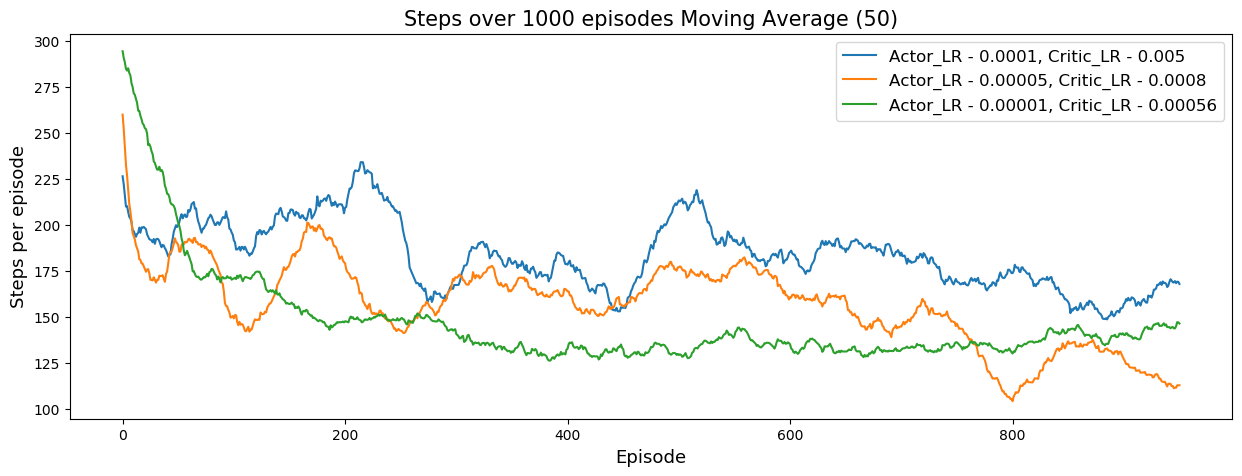

In [5]:
# Plot for the NUMBER OF STEPS VS EPISODES
fig, ax = plt.subplots(1,1,figsize=(15,5))
for x, y in dict_steps.items():
        ax.plot(moving_average(y,50), label='Actor_LR - {0:f}'.format(x[0]).rstrip('0').rstrip('.') + ', Critic_LR - {0:f}'.format(x[1]).rstrip('0').rstrip('.')) 

ax.legend(loc='best', fontsize=12);
ax.set_title('Steps over 1000 episodes Moving Average (50)', fontsize=15);
ax.set_ylabel('Steps per episode', fontsize = 13);
ax.set_xlabel('Episode', fontsize = 13);
plt.show(block = True)

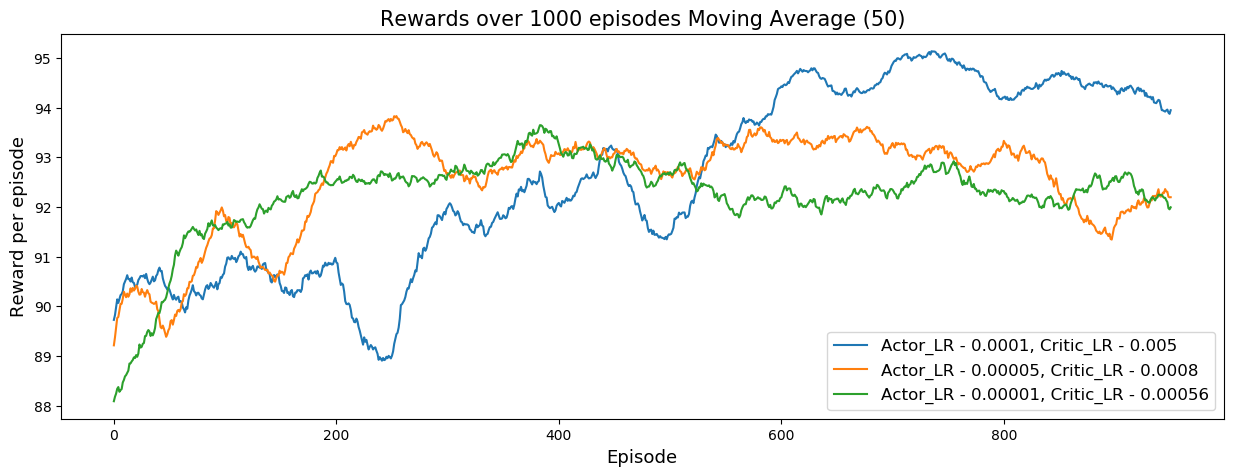

In [9]:
#plot for the REWARDS VS EPISODES
fig, ax = plt.subplots(1,1,figsize=(15,5))
for x, y in dict_rewards.items():
        ax.plot(moving_average(y, 50), label='Actor_LR - {0:f}'.format(x[0]).rstrip('0').rstrip('.') + ', Critic_LR - {0:f}'.format(x[1]).rstrip('0').rstrip('.')) 

ax.legend(loc='best', fontsize=12);
ax.set_title('Rewards over 1000 episodes Moving Average (50)', fontsize=15);
ax.set_ylabel('Reward per episode', fontsize = 13);
ax.set_xlabel('Episode', fontsize = 13);
plt.show();

<a id='part8b'></a>
### 8b Unsuccessful Results

In [ ]:
# Unsuccessful case
# create empty dictionaries to store results
dict_steps_unsuccessful = {}
dict_rewards_unsuccessful = {}

# only running for the below values
rates = [[0.0005,0.001]]

for i in rates:
    lr_actor = i[0]  #set learning rates
    lr_critic = i[1]
    
    # define required placeholders
    action_placeholder = tf.placeholder(tf.float32)
    delta_placeholder = tf.placeholder(tf.float32)
    target_placeholder = tf.placeholder(tf.float32)

    action_tf_var, norm_dist = policy_network(state_placeholder)
    V = value_function(state_placeholder)

    # define actor (policy) loss function
    loss_actor = -tf.log(norm_dist.prob(action_placeholder) + 1e-5) * delta_placeholder
    training_op_actor = tf.train.AdamOptimizer(lr_actor).minimize(loss_actor)

    # define critic (state-value) loss function
    loss_critic = tf.reduce_mean(tf.squared_difference(tf.squeeze(V), target_placeholder))
    training_op_critic = tf.train.AdamOptimizer(lr_critic).minimize(loss_critic)


    gamma = 0.99        #discount factor
    num_episodes = 1000
    run_sess = True     # flag to check if rerun of session is needed

    # a check to re-run training session  (captures only unsuccesful cases) 
    while run_sess == True:
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            steps_tracker = []
            run_episodes = True
            dict_steps_unsuccessful[(lr_actor, lr_critic)] = []       # initialise to empty values in dict for current learning rates 
            dict_rewards_unsuccessful[(lr_actor, lr_critic)] = []     # initialise to empty values in dict for current learning rates 
            
            for episode in range(num_episodes):       # for loop
                # if learning is unsuccesful then break and re-run session
                if run_episodes == False:
                    break
                #receive initial state from E
                state = env.reset()   # state.shape -> (2,)
                reward_total = 0      # counter for reward accumulated
                steps = 0             # counter for steps taken
                done = False

                
                while (not done):     # while loop
                    # for the chosen learning rate if the agents fails to reach goal state 
                    # in any of the initial episodes then set flags, break loops and restart session 
                    if 0 < episode <= 50 and max(steps_tracker[:]) == 999:
                            # set flag to re-run new training session
                            run_sess = True
                            # break out of while loop and then for loop aswell
                            run_episodes = False     # break for loop
                            done = True
                            break                    # break while loop
                    
                    else:   
                        #Sample action according to current policy
                        #action.shape = (1,1)
                        action  = sess.run(action_tf_var, feed_dict={state_placeholder:
                                                                     scale_state(state)})
                        #Execute action and observe reward & next state from E
                        # next_state shape=(2,)    
                        #env.step() requires input shape = (1,)
                        next_state, reward, done, _ = env.step(np.squeeze(action, axis=0)) 
                        steps +=1
                        reward_total += reward
                        #V_of_next_state.shape=(1,1)
                        V_of_next_state = sess.run(V, feed_dict = {state_placeholder: 
                                                                   scale_state(next_state)})  
                        #Set TD Target
                        #target = r + gamma * V(next_state)     
                        target = reward + gamma * np.squeeze(V_of_next_state) 
            
                        # td_error = target - V(s)
                        #needed to feed delta_placeholder in actor training
                        td_error = target - np.squeeze(sess.run(V, feed_dict = 
                                    {state_placeholder: scale_state(state)})) 
            
                        #Update actor by minimizing loss (Actor training)
                        _, loss_actor_val  = sess.run([training_op_actor, loss_actor], 
                                            feed_dict={action_placeholder: np.squeeze(action), 
                                                       state_placeholder: scale_state(state), 
                                                       delta_placeholder: td_error})
                        #Update critic by minimizinf loss  (Critic training)
                        _, loss_critic_val  = sess.run([training_op_critic, loss_critic], 
                                            feed_dict={state_placeholder: scale_state(state), 
                                                       target_placeholder: target})
                    
                        state = next_state
                         # set re run flag to false if agent is unsuccessful (inorder to  terminate the session)
                        run_sess = False
                
                dict_steps_unsuccessful[(lr_actor,lr_critic)].append(steps)
                dict_rewards_unsuccessful[(lr_actor,lr_critic)].append(reward_total)
                steps_tracker.append(steps)
            
                print("Episode: {}, Number of Steps : {}, Cumulative reward: {:0.2f}".format(
                         episode, steps, reward_total))

In [ ]:
# Loop unsuccesful cases

# values to iterate over
rates = [[0.0001,0.005], [0.00005,0.0008], [0.00001,0.00056]]

for i in rates:
    lr_actor = i[0]  # set learning rates
    lr_critic = i[1]
    
    # define required placeholders
    action_placeholder = tf.placeholder(tf.float32)
    delta_placeholder = tf.placeholder(tf.float32)
    target_placeholder = tf.placeholder(tf.float32)

    action_tf_var, norm_dist = policy_network(state_placeholder)
    V = value_function(state_placeholder)

    # define actor (policy) loss function
    loss_actor = -tf.log(norm_dist.prob(action_placeholder) + 1e-5) * delta_placeholder
    training_op_actor = tf.train.AdamOptimizer(lr_actor).minimize(loss_actor)

    # define critic (state-value) loss function
    loss_critic = tf.reduce_mean(tf.squared_difference(tf.squeeze(V), target_placeholder))
    training_op_critic = tf.train.AdamOptimizer(lr_critic).minimize(loss_critic)


    gamma = 0.99        # discount factor
    num_episodes = 1000
    run_sess = True     # flag to check if rerun of session is needed

    # a check to re-run training session  (captures only unsuccesful cases) 
    while run_sess == True:
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            steps_tracker = []
            run_episodes = True
            dict_steps_unsuccessful[(lr_actor, lr_critic)] = []         # initialise to empty values in dict for current learning rates 
            dict_rewards_unsuccessful[(lr_actor, lr_critic)] = []       # initialise to empty values in dict for current learning rates 
            
            for episode in range(num_episodes):       # for loop
                # if learning is unsuccesful then break and re-run session
                if run_episodes == False:
                    break
                #receive initial state from E
                state = env.reset()   # state.shape -> (2,)
                reward_total = 0      # counter for rewards accumulated
                steps = 0             # counter for steps taken
                done = False

                
                while (not done):     # while loop
                    # if agent is successful before 50 epsiodes then set flags,
                    # break loops and restart session
                    if 0 < episode <= 50 and max(steps_tracker[:]) < 999:
                            # set flag to re-run new training session
                            run_sess = True
                            # break out of while loop and then for loop aswell
                            run_episodes = False        # break for loop
                            done = True
                            break                       # break while loop

                    # if agent learns succesfully later on then restart capture to avoid successful learning
                    elif 100 < episode <=300 and np.mean(steps_tracker[-10:]) < 999: 
                            run_sess = True
                            run_episodes = False
                            done = True
                            break
                    else:   
                        #Sample action according to current policy
                        #action.shape = (1,1)
                        action  = sess.run(action_tf_var, feed_dict={state_placeholder:
                                                                     scale_state(state)})
                        #Execute action and observe reward & next state from E
                        # next_state shape=(2,)    
                        #env.step() requires input shape = (1,)
                        next_state, reward, done, _ = env.step(np.squeeze(action, axis=0)) 
                        steps +=1
                        reward_total += reward
                        #V_of_next_state.shape=(1,1)
                        V_of_next_state = sess.run(V, feed_dict = {state_placeholder: 
                                                                   scale_state(next_state)})  
                        #Set TD Target
                        #target = r + gamma * V(next_state)     
                        target = reward + gamma * np.squeeze(V_of_next_state) 
            
                        # td_error = target - V(s)
                        #needed to feed delta_placeholder in actor training
                        td_error = target - np.squeeze(sess.run(V, feed_dict = 
                                    {state_placeholder: scale_state(state)})) 
            
                        #Update actor by minimizing loss (Actor training)
                        _, loss_actor_val  = sess.run([training_op_actor, loss_actor], 
                                            feed_dict={action_placeholder: np.squeeze(action), 
                                                       state_placeholder: scale_state(state), 
                                                       delta_placeholder: td_error})
                        #Update critic by minimizinf loss  (Critic training)
                        _, loss_critic_val  = sess.run([training_op_critic, loss_critic], 
                                            feed_dict={state_placeholder: scale_state(state), 
                                                       target_placeholder: target})
                    
                        state = next_state
                        # set re run flag to false if agents learning is unsuccessful   (terminate the session)
                        run_sess = False
                
                dict_steps_unsuccessful[(lr_actor,lr_critic)].append(steps)
                dict_rewards_unsuccessful[(lr_actor,lr_critic)].append(reward_total)
                steps_tracker.append(steps)
            
                # print the training iteration and accumulated reward for trained network
                print("Episode: {}, Number of Steps : {}, Cumulative reward: {:0.2f}".format(
                         episode, steps, reward_total))

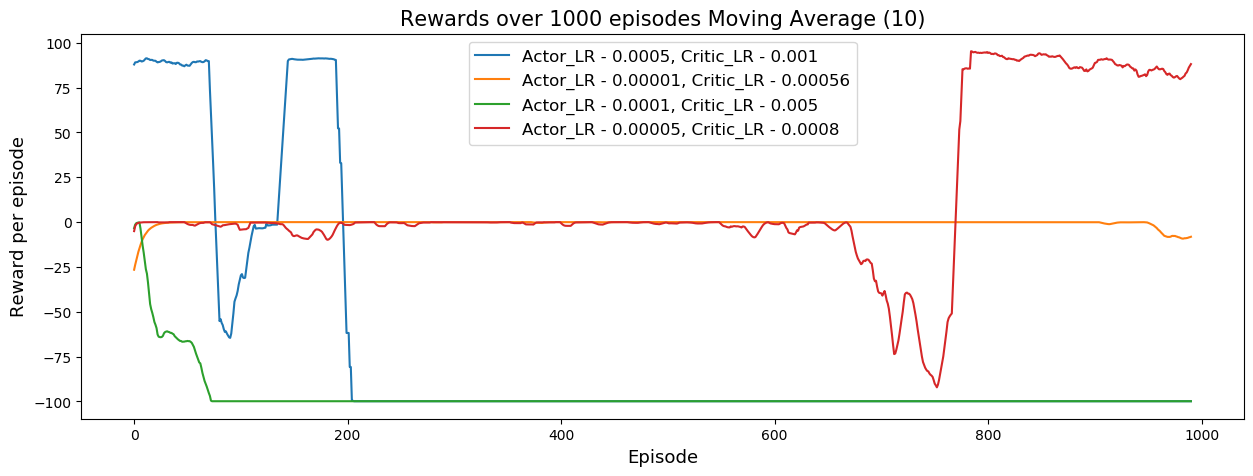

In [10]:
#plot for the Unsuccessful REWARDS VS EPISODES
fig, ax = plt.subplots(1,1,figsize=(15,5))
for x, y in dict_rewards_unsuccessful.items():
        ax.plot(moving_average(y,10), label='Actor_LR - {0:f}'.format(x[0]).rstrip('0').rstrip('.') + ', Critic_LR - {0:f}'.format(x[1]).rstrip('0').rstrip('.')) 

ax.legend(loc='best', fontsize=12)
ax.set_title('Rewards over 1000 episodes Moving Average (10)', fontsize=15);
ax.set_ylabel('Reward per episode', fontsize = 13);
ax.set_xlabel('Episode', fontsize = 13);

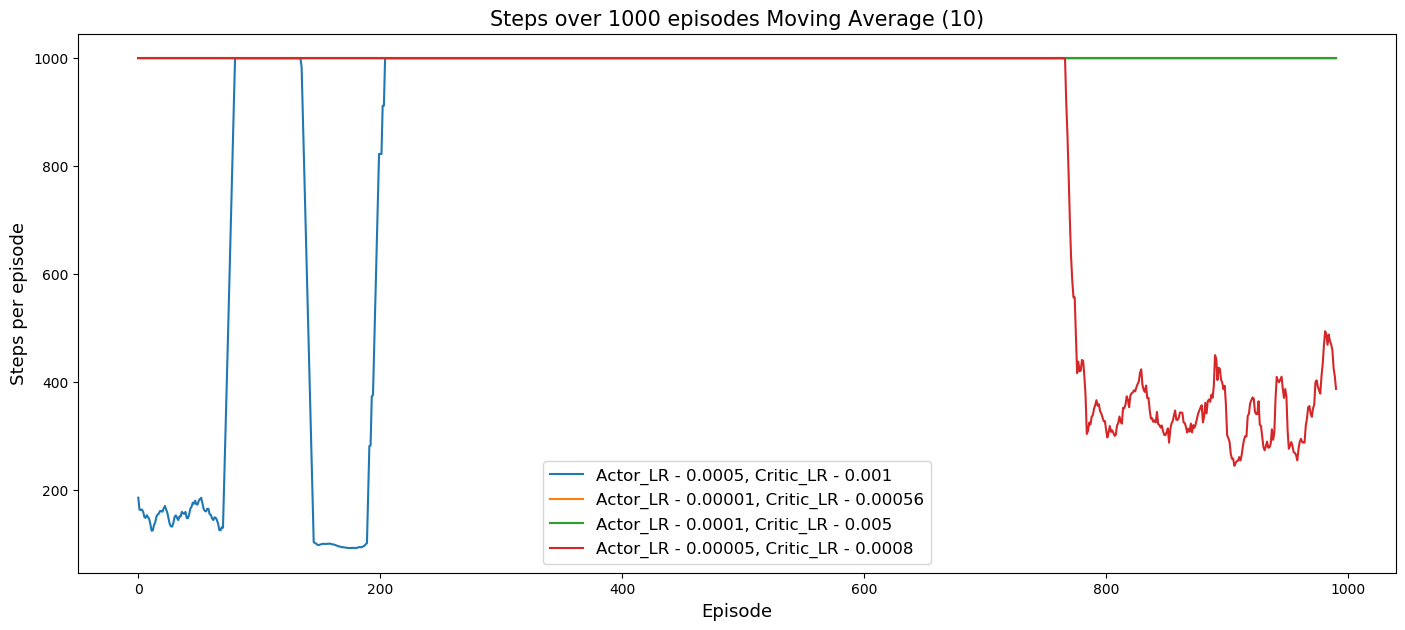

In [11]:
#plot for the unsuccessful STEPS VS EPISODES
fig, ax = plt.subplots(1,1,figsize=(17,7))
for x, y in dict_steps_unsuccessful.items():
        ax.plot(moving_average(y,10), label='Actor_LR - {0:f}'.format(x[0]).rstrip('0').rstrip('.') + ', Critic_LR - {0:f}'.format(x[1]).rstrip('0').rstrip('.')) 

ax.legend(loc='best', fontsize=12)
ax.set_title('Steps over 1000 episodes Moving Average (10)', fontsize=15);
ax.set_ylabel('Steps per episode', fontsize = 13);
ax.set_xlabel('Episode', fontsize = 13);
plt.show()